## Imports and Data Fetching

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport nanslice
%aimport nanslice.jupyter
%aimport QUIT.base
%aimport QUIT.interfaces.rufis
import nibabel as nib
import numpy as np
import requests
import gzip
from os.path import isfile

200403-21:02:32,641 nipype.utils INFO:
	 Running nipype version 1.3.0-rc1 (latest: 1.4.2)


## Setup

In [2]:
if not isfile('classes.mnc'):
    print('Downloading classes')
    params = {'download_for_real':'[Start Download!]',
              'do_download_alias':'phantom_1.0mm_normal_crisp',
              'format_value':'minc',
              'who_name': 'Tobias Wood',
              'who_institution': 'KCL',
              'who_email': 'tobias.wood@kcl.ac.uk'}
    response = requests.get(url='http://brainweb.bic.mni.mcgill.ca/cgi/brainweb1', params=params)
    minc_file = open('classes.mnc', 'wb')
    minc_file.write(response.content)
if not isfile('rf20_C.mnc'):
    print('Downloading B1')
    params = {'download_for_real':'[Start Download!]',
              'do_download_alias':'rf20_C.mnc.gz',
              'format_value':'minc',
              'zip_value':'none',
              'who_name': 'Tobias Wood',
              'who_institution': 'KCL',
              'who_email': 'tobias.wood@kcl.ac.uk'}
    response = requests.get(url='https://brainweb.bic.mni.mcgill.ca/cgi/brainweb1', params=params)
    b1_file = open('rf20_C.mnc', 'wb')
    b1_file.write(response.content)
classes = nanslice.Layer('classes.mnc')
b1_minc = nanslice.Layer('rf20_C.mnc')

In [3]:
# 0=Background
# 1=CSF
# 2=Grey Matter
# 3=White Matter
# 4=Fat
# 5=Muscle/Skin
# 6=Skin
# 7=Skull
# 8=Glial Matter
# 9=Connective
def classes_to_params(M0Vals, T1Vals, T2vals, subsamp=1):
    class_data = classes.image.get_data().astype('int32')
    M0data = np.choose(class_data[::subsamp,::subsamp,::subsamp], M0vals).astype('float32')
    T1data = np.choose(class_data[::subsamp,::subsamp,::subsamp], T1vals).astype('float32')
    T2data = np.choose(class_data[::subsamp,::subsamp,::subsamp], T2vals).astype('float32')
    B1data = b1_minc.image.get_data().astype('float32')[::subsamp,::subsamp,::subsamp]
    # PDdata = np.array(list(map(PDFunc, classes.image.get_data())))
    M0image = nib.nifti1.Nifti1Image(M0data, affine=classes.image.affine)
    T1image = nib.nifti1.Nifti1Image(T1data, affine=classes.image.affine)
    T2image = nib.nifti1.Nifti1Image(T2data, affine=classes.image.affine)
    B1image = nib.nifti1.Nifti1Image(B1data, affine=classes.image.affine)
    nib.save(M0image, 'M0.nii.gz')
    nib.save(T1image, 'T1.nii.gz')
    nib.save(T2image, 'T2.nii.gz')
    nib.save(B1image, 'B1.nii.gz')

## Simulate and Display Image

In [4]:
M0vals = np.array([0, 1, 0.8, 0.7, 0, 0, 0, 0, 0, 0])
T1vals = np.array([0, 3.0, 1.3, 0.9, 0, 0, 0, 0, 0, 0])
T2vals = np.array([0, 0.5, 0.08, 0.06, 0, 0, 0, 0, 0, 0])
classes_to_params(M0vals, T1vals, T2vals, 2)

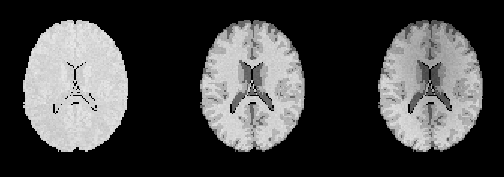

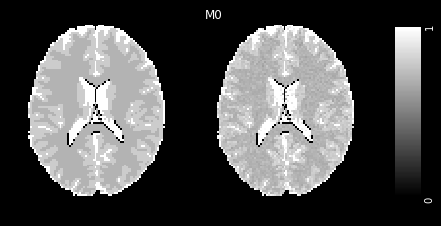

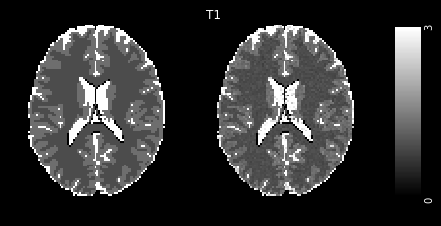

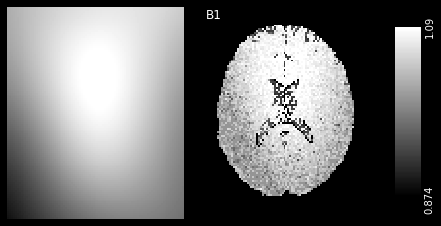

In [5]:
seq = {
        "TR": 0.002,
        "Tramp": 0.01,
        "Tspoil": 0.05,
        "FA": [2, 8, 8],
        "Trf": [28e-6, 28e-6, 28e-6],
        "spokes_per_seg": 48,
        "groups_per_seg": [1, 1, 1],
        "prep_FA": [0, 0, 360],
        "prep_df": [0, 0, 0],
        "prep_Trf": 0.001,
        "prep_p1": 1.,
        "prep_p2": 1.
    }
region='45,0,0,1,109,91'
inputs={'M0':'M0.nii.gz', 'T1':'T1.nii.gz', 'B1':'B1.nii.gz'}
sim_result = QUIT.interfaces.rufis.SteadyStateSim(sequence=seq, in_file='sim.nii.gz', noise=0.0005, mask='M0.nii.gz', subregion=region, **inputs).run()
display(nanslice.jupyter.timeseries(sim_result.outputs.out_file, clim=[0,0.025]))
mupa = QUIT.interfaces.rufis.SteadyState(sequence=seq, in_file='sim.nii.gz', mask_file='M0.nii.gz', subregion=region).run()
for name, fname in inputs.items():
    display(nanslice.jupyter.compare(fname, 'SS_' + fname, axis='z', title=name))

In [52]:
seq = {
        "TR": 0.002,
        "Tramp": 0.01,
        "Tspoil": 0.05,
        "FA": [2, 2, 2, 8, 8],
        "Trf": [28e-6, 228e-6, 28e-6, 28e-6],
        "spokes_per_seg": 48,
        "groups_per_seg": [1, 1, 1, 1],
        "prep_FA": [0, 180,  0, 360],
        "prep_df": [0, 0.25, 0, 0],
        "prep_Trf": 0.01,
        "prep_p1": 1.,
        "prep_p2": 1.
    }
region='45,0,0,1,109,91'
inputs={'M0':'M0.nii.gz', 'T1':'T1.nii.gz', 'T2':'T2.nii.gz', 'B1':'B1.nii.gz'}
sim_result = QUIT.interfaces.rufis.SteadyStateSim(sequence=seq, fitT2=True, in_file='sim.nii.gz', noise=0.0005, mask='M0.nii.gz', subregion=region, **inputs).run()
display(nanslice.jupyter.timeseries(sim_result.outputs.out_file, clim=[0,0.025]))
mupa = QUIT.interfaces.rufis.SteadyState(sequence=seq, fitT2=True, in_file='sim.nii.gz', mask_file='M0.nii.gz', subregion=region).run()
for name, fname in inputs.items():
    display(nanslice.jupyter.compare(fname, 'SS_' + fname, axis='z', title=name))

SyntaxError: EOL while scanning string literal (<ipython-input-52-22fd22794563>, line 6)